In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from lmfit import minimize, Parameters, report_fit
import pandas as pd
from scipy.constants import N_A
import seaborn as sns

In [12]:
Target_cell_number = 5e4
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]
z0 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [17]:
def model_S_monospecific(t, z, Ainit, rtot, kon, koff, k2):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/rtot) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

     return [dA10, dA11]

def solve_ode(x, params):

    solution_vals = np.zeros_like(x)
    

    rtot1 = params[f'rtot_{1}']
    kon1 = params[f'kon_{1}']
    k21 = params[f'k2_{1}']
    koff1 = params[f'koff_{1}']
    #MFI_factor = params[f'MFI_factor']

    for j, val in enumerate(x):
        A0 = 1e-9*val

        z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(A0, rtot1, kon1,
                                                                                            koff1, k21))

        P_A10 = z.y[0]
        P_A11 = z.y[1]

        A10_STST = P_A10[-1]
        A11_STST = P_A11[-1]

        Ab = A10_STST + A11_STST

        solution_vals[j] = Ab#*MFI_factor

    return np.asarray(solution_vals)

def objective(params, x, data):
    resid = np.zeros_like(data)

    for i in range(len(data)):
        sol = solve_ode(x, params)
        resid[i]= data[i] - sol[i]
    
    return resid

In [14]:
kons = [3.1e5, 2.6e5, 3e5, 3.8e5, 3.3e5]
koffs = [2.4e-4, 4.8e-4, 2.7e-3, 8.5e-3, 9.6e-2]

df = pd.read_csv('Mazor_diff_kd.csv')
xdata1 = np.asarray(df['Default Dataset'])

y_data1 = [np.asarray(df[f'Unnamed: {2*i + 1}'])*1e4 for i in range(5)]

In [15]:
d = {}
for i, data in enumerate(y_data1):
    d[f"interp_func_{i+1}"] = interp1d(xdata1, data)

A0s1 = [1e-11, 1e-10, 1e-9, 1e-8]
A0s = []
vals = np.linspace(4, 6, 20)
for x in A0s1:
    for val in vals:
        A0s.append(x*val)
A0s1 = np.asarray(A0s)/1e-9
xdata = np.concatenate((xdata1, A0s1))

ydata = []
for j in range(5):
    interp_func = d[f"interp_func_{j+1}"]
    ydata.append(np.concatenate((y_data1[j], interp_func(A0s1))))
    

In [149]:
parameters = []
ydata.remove(ydata[0])
for i in range(len(ydata)):
    fit_params = Parameters()


    fit_params.add(f'rtot_{1}', value = 1e4, min=0, max = 1e6)
    fit_params.add(f'kon_{1}', value = kons[i], vary=False)# min=1e4, max = 1e7)
    fit_params.add(f'k2_{1}', value = 200, min=3, max = 1e3)
    fit_params.add(f'koff_{1}', value = koffs[i],  min=0, max = 1)
    fit_params.add(f'MFI_factor', value=1, min=0)

    out = minimize(objective, fit_params, args=(xdata, ydata[i]))
    parameters.append(out.params)

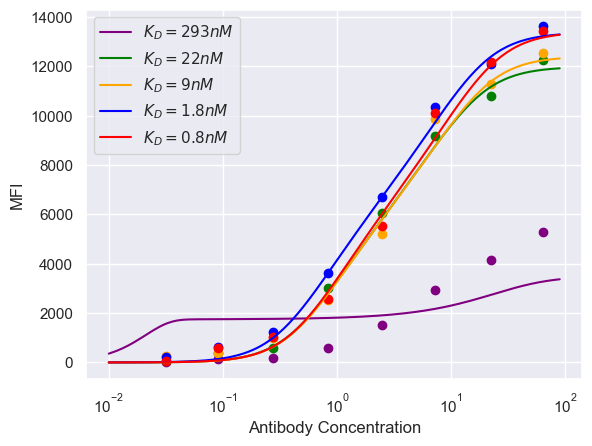

In [181]:
sns.set_theme()
A0s1 = [1e-11, 1e-10, 1e-9, 1e-8]
A0s = []
vals = np.linspace(1, 9, 50)
for x in A0s1:
    for val in vals:
        A0s.append(x*val)
A0s1 = np.asarray(A0s)/1e-9
labels = np.flip(np.asarray([r'$K_D=0.8nM$', r'$K_D=1.8nM$', r'$K_D=9nM$', r'$K_D=22nM$', r'$K_D=293nM$']))
colors = np.flip(np.asarray(['red', 'blue', 'orange', 'green', 'purple']))

for i in range(len(ydata)):
    plt.scatter(xdata1, y_data1[i], color=colors[i])
    plt.plot(A0s1, solve_ode(A0s1, parameters[i]), color=colors[i], label=labels[i])

plt.legend(loc='best')
plt.xlabel('Antibody Concentration')
plt.ylabel('MFI')
plt.xscale('log')


In [18]:
fit_params = Parameters()


fit_params.add(f'rtot_{1}', value = 1e2, min=0, max = 1e6)
fit_params.add(f'kon_{1}', value = kons[1], vary=False)# min=1e4, max = 1e7)
fit_params.add(f'k2_{1}', value = 20, min=3, max = 1e3)
fit_params.add(f'koff_{1}', value = koffs[1],  min=0, max = 1)
#fit_params.add(f'MFI_factor', value=1, min=0)

out = minimize(objective, fit_params, args=(xdata, ydata[1]), max_nfev=500)


In [9]:
print(report_fit(out.params))

[[Variables]]
    rtot_1:      7070.64288 +/- 203325.673 (2875.63%) (init = 100)
    kon_1:       260000 (fixed)
    k2_1:        9.63938281 +/- 277.281242 (2876.55%) (init = 20)
    koff_1:      0.94112985 +/- 27.0730643 (2876.66%) (init = 0.00048)
    MFI_factor:  1.69508972 +/- 48.7424876 (2875.51%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(rtot_1, MFI_factor) = -1.000
    C(koff_1, MFI_factor) = 1.000
    C(rtot_1, koff_1)     = -1.000
    C(k2_1, koff_1)       = 1.000
    C(k2_1, MFI_factor)   = 1.000
    C(rtot_1, k2_1)       = -1.000
None


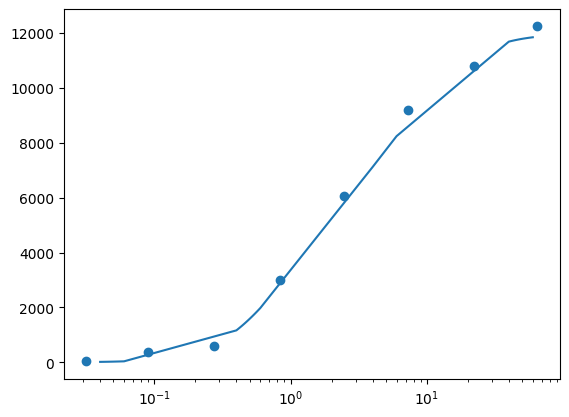

In [10]:
plt.scatter(xdata1, y_data1[1])
plt.plot(A0s1, solve_ode(A0s1, out.params))
    
plt.xscale('log')